
** You need to input " PubChem_compound.csv " in the folders/files so that the code can run  **


CSV File can be found here otherwise at : https://pubchem.ncbi.nlm.nih.gov/classification/#hid=72


Examples to run with the code :

NC(C=C(C1)C(C)C)=CC=1N

O=C(NC(C=CC1O)=CC=1)NC(C=CC1Cl)=CC=1

ClC(=CC=C1OC(=CC2)C(Cl)=CC=2C)C=C1

NC(=CC1C(C=CC2)=CC=2)C(=CC=1C)C(C)C(C)Cl

In [1]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 24.4 MB/s eta 0:00:00


In [2]:
pip install rdkit-pypi ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.7 MB/s eta 0:00:00


In [4]:
# Import Libraries
import pandas as pd                                                             # For handling structured data, such as loading, processing, and analyzing datasets
import numpy as np                                                              # For numerical computing
import ipywidgets as widgets                                                    # For creating interactive widgets in Jupyter notebooks

from rdkit import Chem                                                          # Imports the Chem module from the rdkit library
from rdkit.Chem import Draw                                                     # For drawing molecules
from rdkit.Chem import Descriptors, rdMolDescriptors, QED, Draw, Crippen        # Imports specific modules and classes from RDKit’s Chem library
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect, DataStructs       # Generates a Morgan fingerprint
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams         # Catalogs that screen molecules for certain substructure patterns or functional groups (used for PAINS (Pan-Assay INterference compounds) filtering)

from IPython.display import display                                             # For displaying the structure in the notebook
from IPython.display import display, HTML                                       # For displaying website to draw structure to get SMILES

from sklearn.ensemble import RandomForestClassifier                             # Random Forest Classifier
from sklearn.model_selection import train_test_split                            # To split a dataset into training and testing sets
from sklearn.metrics import accuracy_score, classification_report               # Get metrics, including precision, recall, and F1 score for each class

Draw structure on PubChem and view using SMILES

In [5]:
# Display instructions and link to PubChem Sketcher
display(HTML("<h3>Instructions:</h3>"
             "<p>1. Open the <a href='https://pubchem.ncbi.nlm.nih.gov/edit3/index.html' target='_blank'>PubChem Sketcher</a> in a new tab.</p>"
             "<p>2. Draw your molecule in the sketcher and export it as a SMILES string by clicking <b>SMILES String is on the top bar</b>.</p>"
             "<p>3. Copy the SMILES code and paste it into the input box below to view the structure in Colab.</p>"
             "<p>   Once in the input box, and structure appears, run the next part of the code"))

# Input field for SMILES
userSmiles = widgets.Text(
    value='',
    placeholder='Paste SMILES here...',
    description='SMILES:',
    disabled=False
)

# Output area for molecule image
userMoleculeDrawing = widgets.Output()

# Function to display molecule from SMILES
def drawMolecule(change):
    with userMoleculeDrawing:
        userMoleculeDrawing.clear_output()  # Clear previous output
        smiles = userSmiles.value
        try:
            molecule = Chem.MolFromSmiles(smiles)
            if molecule:
                moleculeImage = Draw.MolToImage(molecule)
                display(moleculeImage)
            else:
                print("Invalid SMILES string")
        except Exception as e:
            print("Error:", e)

# Trigger molecule display when SMILES is entered
userSmiles.observe(drawMolecule, names='value')
# Display widgets
display(userSmiles, userMoleculeDrawing)

Text(value='', description='SMILES:', placeholder='Paste SMILES here...')

Output()

**Goal 1 and 2.**

Checking to see if structure follow Lipinski's Rule of 5.

Will tell you if strucure is Drug-like or not Drug-like

Will give Random Forest Classification report

Will output molecular descriptors

Read in the PubChem data into a dataframe and apply the Lipinski's rule on PubChem data

In [6]:
# Load PubChem data
pubChemDataset = pd.read_csv("PubChem_compound.csv")

# Filter columns needed for analysis
pubChemDataframe = pubChemDataset[['canonicalsmiles', 'mw', 'polararea', 'xlogp', 'hbonddonor', 'hbondacc', 'rotbonds']].copy()

# Define drug-likeness label based on Lipinski's Rule of Five
def testLipinskiRule (userMolecule):
    return userMolecule['mw'] <= 500 and userMolecule['xlogp'] <= 5 and userMolecule['hbonddonor'] <= 5 and userMolecule['hbondacc'] <= 10

pubChemDataframe['drugLikeness'] = pubChemDataframe.apply(testLipinskiRule , axis=1)
pubChemDataframe['valueDrugLikeness'] = pubChemDataframe['drugLikeness'].astype(int)

1. Train the RandomForest Model with the Pubchem data & their Lipinski's rule results to predict drug-likeness of inputted molecule using its descriptors
2. Evaluate the model

In [7]:
# Prepare features and labels and Train-Test Split
moleculeDescriptorsX = pubChemDataframe[['mw', 'polararea', 'xlogp', 'hbonddonor', 'hbondacc', 'rotbonds']]
moleculeDruglikeness = pubChemDataframe['valueDrugLikeness']
trainX, testX, trainY, testY = train_test_split(moleculeDescriptorsX, moleculeDruglikeness, test_size=0.2, random_state=42)

# Initialize and Train RandomForest Model and evaluate
randomForestModel = RandomForestClassifier(random_state=42)
randomForestModel.fit(trainX, trainY)
randomForestPrediction = randomForestModel.predict(testX)
print("Random Forest Accuracy:", accuracy_score(testY, randomForestPrediction))
print("Random Forest Classification Report:\n", classification_report(testY, randomForestPrediction))


Random Forest Accuracy: 1.0
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2407
           1       1.00      1.00      1.00      1548

    accuracy                           1.00      3955
   macro avg       1.00      1.00      1.00      3955
weighted avg       1.00      1.00      1.00      3955



Function to calculate the inputted moleculer descriptors using RDkit

In [8]:
# Descriptor Calculation Function
def findMoleculeDescriptors(moleculeSmiles):
    molecule = Chem.MolFromSmiles(moleculeSmiles)
    if molecule is None:
        return pd.Series([np.nan] * 8, index=['mw', 'polararea', 'xlogp', 'hbonddonor', 'hbondacc', 'rotbonds', 'molar_refractivity', 'qed'])
    moleculeDescriptors = {
        'mw': Descriptors.MolWt(molecule),
        'polararea': rdMolDescriptors.CalcTPSA(molecule),
        'xlogp': Descriptors.MolLogP(molecule),
        'hbonddonor': Descriptors.NumHDonors(molecule),
        'hbondacc': Descriptors.NumHAcceptors(molecule),
        'rotbonds': Descriptors.NumRotatableBonds(molecule),
        'molar_refractivity': Descriptors.MolMR(molecule),
        'qed': QED.qed(molecule)
    }
    return pd.Series(moleculeDescriptors)

1. input a molecules smiles
2. predict inputted molecule drug-likeness using the RandomForest Model
3. check if its descriptor's follow Lipinski's rule
4. output the prediction and the results Lipinski's rule

In [9]:
# Prediction Function
def rfUserMoleculeDruglikeness(smiles, moleculeDescriptors, model):
    if moleculeDescriptors.isnull().any():
        return "Invalid SMILES Value"
    # Prepare input for model and predict drug-likeness
    featuresRF = pd.DataFrame([moleculeDescriptors], columns=moleculeDescriptorsX.columns)
    druglikenessRF = model.predict(featuresRF)[0]
    outputDruglikenessRF = "Drug-like" if druglikenessRF == 1 else "Non-drug-like"
    # Lipinski’s Rule check and ouput
    lipinskiRule = {
        'Molecular Weight (≤500)': "Pass" if moleculeDescriptors['mw'] <= 500 else "Fail",
        'LogP (≤5)': "Pass" if moleculeDescriptors['xlogp'] <= 5 else "Fail",
        'H-bond Donors (≤5)': "Pass" if moleculeDescriptors['hbonddonor'] <= 5 else "Fail",
        'H-bond Acceptors (≤10)': "Pass" if moleculeDescriptors['hbondacc'] <= 10 else "Fail",
    }
    lipinskiRuleOutput = all(value == "Pass" for value in lipinskiRule.values())
    lipinskiOutput = {
        "Prediction": outputDruglikenessRF,
        "Lipinski's Rule": "Pass" if lipinskiRuleOutput else "Fail",
        "Lipinski Criteria": lipinskiRule
    }
    return lipinskiOutput

# user SMILES and descriptors
userInputtedSmiles = userSmiles.value
moleculeDescriptors = findMoleculeDescriptors(userInputtedSmiles)
lipinskiOutput = rfUserMoleculeDruglikeness(userInputtedSmiles, moleculeDescriptors, randomForestModel)
#print results
printTableFormat = {
    "Random Forest and Lipinski's results": ["Random Forest Prediction", "Lipinski's Rule"] + list(lipinskiOutput['Lipinski Criteria'].keys()),
    "Result": [lipinskiOutput["Prediction"], lipinskiOutput["Lipinski's Rule"]] + list(lipinskiOutput['Lipinski Criteria'].values())
}
rfLipinskiTable = pd.DataFrame(printTableFormat)
rfLipinskiTable.set_index("Random Forest and Lipinski's results", inplace=True)
rfLipinskiTable


,Result
Random Forest and Lipinski's results,
Random Forest Prediction,Drug-like
Lipinski's Rule,Pass
Molecular Weight (≤500),Pass
LogP (≤5),Pass
H-bond Donors (≤5),Pass
H-bond Acceptors (≤10),Pass


Function to check if the molecule matches any PAINS substructure

In [10]:
# PAINS Filter Check Function
def testPAINS(molecule):
    painParameters = FilterCatalogParams()
     # Add PAINS substructure filters
    painParameters.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
    painCatalog = FilterCatalog(painParameters)
    if painCatalog.HasMatch(molecule):
        return True
    return False

Calculates Verber's, Ghoss, Egan Rules and QED score.

In [11]:
# Drug-Likeness Prediction with Enhanced Criteria
def testDruglikeness(smiles, moleculeDescriptors):
    molecule = Chem.MolFromSmiles(smiles)
    if moleculeDescriptors.isnull().any() or molecule is None:
        return "Invalid SMILES"
    moreDruglikenessTests = {
        "Veber’s Rule (TPSA ≤ 140, Rotatable Bonds ≤ 10)": "Pass" if (moleculeDescriptors['polararea'] <= 140 and moleculeDescriptors['rotbonds'] <= 10) else "Fail",
        "Ghose Rule (MW 160-480, LogP -0.4 to 5.6, Molar Refractivity 40-130)": "Pass" if (160 <= moleculeDescriptors['mw'] <= 480 and -0.4 <= moleculeDescriptors['xlogp'] <= 5.6 and 40 <= moleculeDescriptors['molar_refractivity'] <= 130) else "Fail",
        "Egan’s Rule (LogP ≤ 5.88, TPSA ≤ 131)": "Pass" if (moleculeDescriptors['xlogp'] <= 5.88 and moleculeDescriptors['polararea'] <= 131) else "Fail",
        "QED Score (≤1)": "Pass" if moleculeDescriptors['qed'] <= 1 else "Fail",
        "PAINS Filter": "Fail" if testPAINS(molecule) else "Pass"
    }
    # Check if all criteria except PAINS are passed
    passedTestsNonPain = all(value == "Pass" for key, value in moreDruglikenessTests.items() if key != "PAINS Filter")
    passedTests = passedTestsNonPain and moreDruglikenessTests["PAINS Filter"] == "Pass"
    return moreDruglikenessTests

#run extra tests and print results
moreTestResults = testDruglikeness(userInputtedSmiles, moleculeDescriptors)
printFormatResults = pd.DataFrame.from_dict(moreTestResults, orient='index', columns=['Result'])
printFormatResults.index.name = "More test results"
printFormatResults


,Result
More test results,
"Veber’s Rule (TPSA ≤ 140, Rotatable Bonds ≤ 10)",Pass
"Ghose Rule (MW 160-480, LogP -0.4 to 5.6, Molar Refractivity 40-130)",Fail
"Egan’s Rule (LogP ≤ 5.88, TPSA ≤ 131)",Pass
QED Score (≤1),Pass
PAINS Filter,Pass


**Goal 3.** Find similar molecules


Function to calculate similarities between the inputted moleculor descriptor using Euclidean distance and the descriptors in the dataset

In [12]:
#Function to calculate similarity between two descriptor dictionaries using Euclidean distance
def findSimiarityBetweenDescriptors(userDescriptors, databaseDescriptors):
    similarKeys = userDescriptors.keys() & databaseDescriptors.keys()
    descriptorsDistance = sum((userDescriptors[key] - databaseDescriptors[key]) ** 2 for key in similarKeys) ** 0.5
    return descriptorsDistance

Function to find the top 10 similar molecules

In [13]:
# Define a function to find the top 10 similar molecules in the dataset
def findMostMatched(smiles, dataset, numberSimilar=10):
    UserMoleculeDescriptors = findMoleculeDescriptors(smiles)
    UserMoleculeDescriptors= {
        'mw': UserMoleculeDescriptors['mw'],
        "polararea": UserMoleculeDescriptors['polararea'],
        "xlogp": UserMoleculeDescriptors['xlogp'],
        "hbonddonor": UserMoleculeDescriptors['hbonddonor'],
        "hbondacc": UserMoleculeDescriptors['hbondacc'],
        "rotbonds": UserMoleculeDescriptors['rotbonds']
    }
    descriptorsDistances = []
    # Loop through dataset to calculate similarity with user molecule
    for datasetColumn, datasetRow in dataset.iterrows():
        databaseDescriptor = {
            "mw": datasetRow['mw'],
            "polararea": datasetRow['polararea'],
            "xlogp": datasetRow['xlogp'],
            "hbonddonor": datasetRow['hbonddonor'],
            "hbondacc": datasetRow['hbondacc'],
            "rotbonds": datasetRow['rotbonds']
        }
        moleculeDistance = findSimiarityBetweenDescriptors(UserMoleculeDescriptors, databaseDescriptor)
        descriptorsDistances.append((moleculeDistance, datasetRow))
    # Sort distances and get the top 10 matches
    mostMatched = sorted(descriptorsDistances, key=lambda x: x[0])[:numberSimilar]
    return mostMatched, UserMoleculeDescriptors

Calculate the match percentage for the top 10 matches and only print matches that above 0.0% with their descriptor and drawing

User Molecule:
mw: 150.22499999999997
polararea: 52.04
xlogp: 1.9744000000000002
hbonddonor: 2.0
hbondacc: 2.0
rotbonds: 1.0


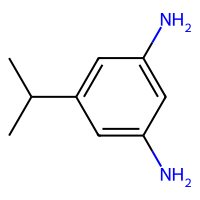


Similar Molecules:

Match 1 - Smiles: C1=CC(=CC=C1CC(=O)O)O (Distance: 6.07, Match: 70.22%)
mw: 152.15
polararea: 57.5
xlogp: 0.8
hbonddonor: 2
hbondacc: 3
rotbonds: 2


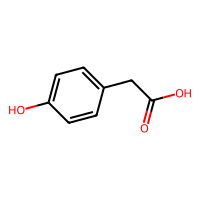


Match 2 - Smiles: C1=CC=C(C=C1)CN=C=S (Distance: 8.12, Match: 60.21%)
mw: 149.21
polararea: 44.4
xlogp: 3.2
hbonddonor: 0
hbondacc: 2
rotbonds: 2


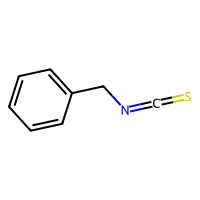


Match 3 - Smiles: CC(C[N+](C)(C)C)OC(=O)N (Distance: 11.61, Match: 43.08%)
mw: 161.22
polararea: 52.3
xlogp: 0.0
hbonddonor: 1
hbondacc: 2
rotbonds: 4


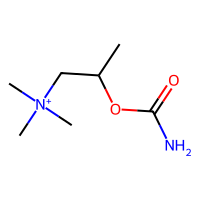


Match 4 - Smiles: C1=CC=C(C(=C1)C(=O)O)O (Distance: 13.32, Match: 34.70%)
mw: 138.12
polararea: 57.5
xlogp: 2.3
hbonddonor: 2
hbondacc: 3
rotbonds: 1


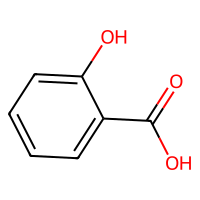


Match 5 - Smiles: C[N+](C)(C)CC(CC(=O)O)O (Distance: 13.83, Match: 32.23%)
mw: 162.21
polararea: 57.5
xlogp: -0.8
hbonddonor: 2
hbondacc: 3
rotbonds: 4


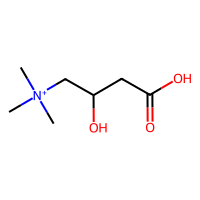


Match 6 - Smiles: C[N+](C)(C)CC(CC(=O)[O-])O (Distance: 14.18, Match: 30.49%)
mw: 161.2
polararea: 60.4
xlogp: -0.2
hbonddonor: 1
hbondacc: 3
rotbonds: 3


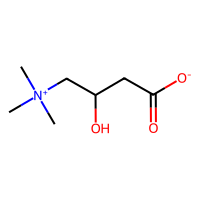


Match 7 - Smiles: C1=CC=C(C=C1)CCC(=O)O (Distance: 14.91, Match: 26.91%)
mw: 150.17
polararea: 37.3
xlogp: 1.8
hbonddonor: 1
hbondacc: 2
rotbonds: 3


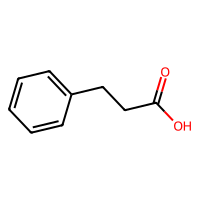


Match 8 - Smiles: CCCCCCCC(=O)O (Distance: 16.75, Match: 17.90%)
mw: 144.21
polararea: 37.3
xlogp: 3.0
hbonddonor: 1
hbondacc: 2
rotbonds: 6


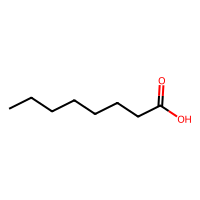


Match 9 - Smiles: C1=CC=C(C(=C1)C(=O)O)N (Distance: 17.31, Match: 15.15%)
mw: 137.14
polararea: 63.3
xlogp: 1.2
hbonddonor: 2
hbondacc: 3
rotbonds: 1


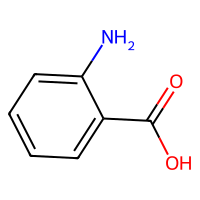

In [15]:
#Function to calculate match percentage using distance
def PercentMatch(distanceMolecule, distanceMaximum):
    return max(0, 100 - (distanceMolecule / distanceMaximum) * 100)

#Function to display the results
def printMatchedMolecules(userInputtedSmiles, matches, UserMoleculeDescriptors):
    distanceMaximum = max([distance[0] for distance in matches])
    print("User Molecule:")
    for key, value in UserMoleculeDescriptors.items():
        print(f"{key}: {value}")
    molecule = Chem.MolFromSmiles(userInputtedSmiles)
    moleculeImage = Draw.MolsToImage([molecule], subImgSize=(200, 200))
    display(moleculeImage)
    print("\nSimilar Molecules:")
    for i, (distance, match) in enumerate(matches, 1):
        match_percentage = PercentMatch(distance, distanceMaximum)
        if (match_percentage!=0.0):
          molecule = Chem.MolFromSmiles(match['canonicalsmiles'])
          print(f"\nMatch {i} - Smiles: {match['canonicalsmiles']} (Distance: {distance:.2f}, Match: {match_percentage:.2f}%)")
          for key in UserMoleculeDescriptors.keys():
              print(f"{key}: {match[key]}")
          moleculeImage = Draw.MolsToImage([molecule], submoleculeImageSize=(200, 200))
          display(moleculeImage)

# find similar molecules and print results
matches, UserMoleculeDescriptors = findMostMatched(userInputtedSmiles, pubChemDataframe, numberSimilar=10)
if matches:
    printMatchedMolecules(userInputtedSmiles, matches, UserMoleculeDescriptors)
else:
    print("No matches found")
